In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
train = pd.read_csv('champs-scalar-coupling/train.csv')
structures = pd.read_csv('champs-scalar-coupling/structures.csv')
test = pd.read_csv('champs-scalar-coupling/test.csv')

# Data Overview

with the help of https://www.kaggle.com/artgor/molecular-properties-eda-and-models

In [3]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {structures['atom'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 5 unique atoms.
There are 8 unique types.


In [4]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02


In [5]:
plt.style.use('seaborn')

there are 709416 1JHC's
there are 378036 2JHH's
there are 43363 1JHN's
there are 119253 2JHN's
there are 1140674 2JHC's
there are 590611 3JHH's
there are 1510379 3JHC's
there are 166415 3JHN's


<BarContainer object of 8 artists>

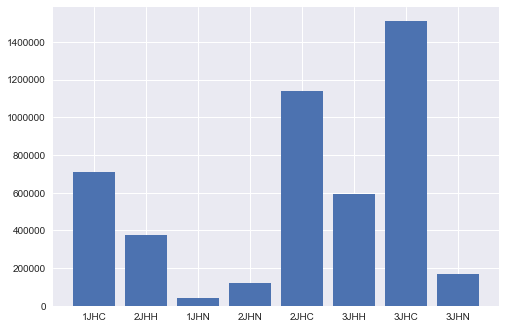

In [6]:
# coupling types (train)

c_labels = pd.unique(train['type'])
c_counts = []
for c_type in pd.unique(train['type']):
    count = (train.loc[train['type'] == c_type]).count(axis = 0)['id']
    c_counts.append(count)
    print(f"there are {count} {c_type}'s")
plt.bar(c_labels, c_counts)

there are 613138 2JHC's
there are 380609 1JHC's
there are 317435 3JHH's
there are 811999 3JHC's
there are 203126 2JHH's
there are 24195 1JHN's
there are 90616 3JHN's
there are 64424 2JHN's


<BarContainer object of 8 artists>

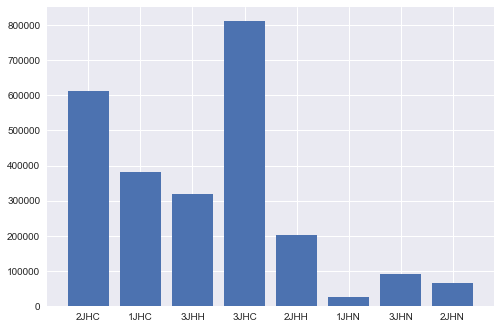

In [7]:
# coupling types (test)

c_labels = pd.unique(test['type'])
c_counts = []
for c_type in pd.unique(test['type']):
    count = (test.loc[test['type'] == c_type]).count(axis = 0)['id']
    c_counts.append(count)
    print(f"there are {count} {c_type}'s")
plt.bar(c_labels, c_counts)

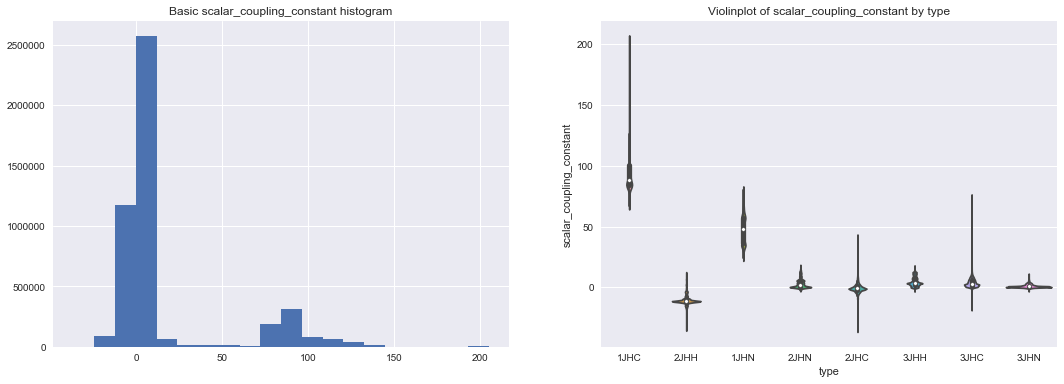

In [8]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=20);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

Notes: 
* Scalar coupling constant has a bimodal histogram
* Different coupling types have very different values of scalar coupling constant 

# Visualization

In [4]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [5]:
# map structure (train)

df_train = map_atom_info(train, 0)
df_train = map_atom_info(df_train, 1)

# map structure (test) 

df_test = map_atom_info(test, 0)
df_test = map_atom_info(df_test, 1)

In [11]:
# create distance feature (train)

struct_0 = df_train[['x_0', 'y_0', 'z_0']].values
struct_1 = df_train[['x_1', 'y_1', 'z_1']].values

x_d = np.absolute(struct_0[:,0] - struct_1[:,0])
df_train['dist_x'] = x_d

y_d = np.absolute(struct_0[:,1] - struct_1[:,1])
df_train['dist_y'] = y_d

z_d = np.absolute(struct_0[:,2] - struct_1[:,2])
df_train['dist_z'] = z_d

distance = np.linalg.norm(struct_0 - struct_1, axis=1)
df_train['dist'] = distance

# create distance feature (test)

struct_0 = df_test[['x_0', 'y_0', 'z_0']].values
struct_1 = df_test[['x_1', 'y_1', 'z_1']].values

x_d = np.absolute(struct_0[:,0] - struct_1[:,0])
df_test['dist_x'] = x_d

y_d = np.absolute(struct_0[:,1] - struct_1[:,1])
df_test['dist_y'] = y_d

z_d = np.absolute(struct_0[:,1] - struct_1[:,1])
df_test['dist_z'] = z_d

distance = np.linalg.norm(struct_0 - struct_1, axis=1)
df_test['dist'] = distance

[Text(0,0.5,'coupling'), Text(0.5,0,'dist')]

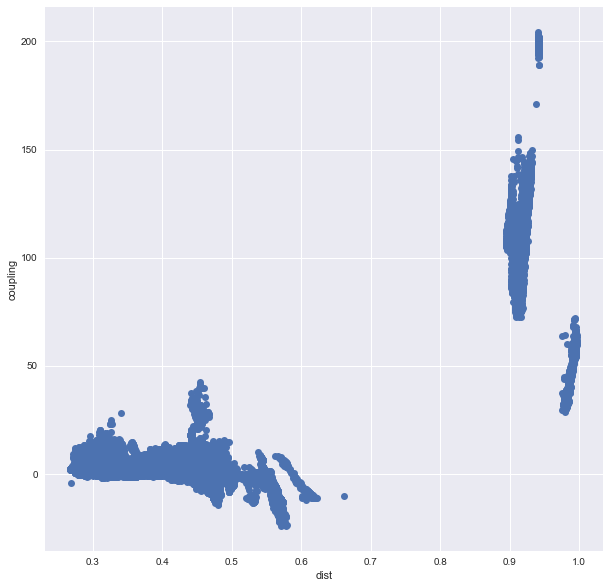

In [12]:
# 1/dist vs scalar_coupling_constant
fig, ax = plt.subplots(1, 1, figsize=(10,10))

x = np.array(df_train['dist']).reshape(-1, 1)
y = np.array(df_train['scalar_coupling_constant']).reshape(-1, 1)

ax.plot(1/x[:100000],y[:100000],'o')

ax.set(xlabel='dist', ylabel='coupling')

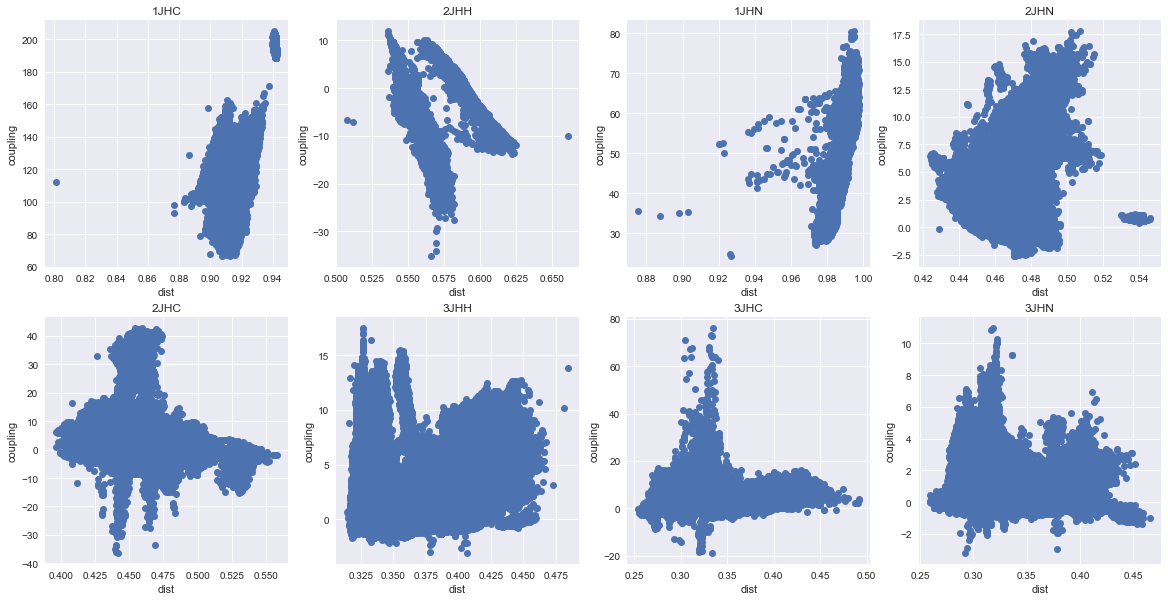

In [13]:
# 1/dist vs scalar_coupling_constant (for each coupling type)
fig, axs = plt.subplots(2, 4, figsize=(20,10))
row = col = 0

for c_type in pd.unique(df_train['type']):
    df = df_train.loc[df_train['type'] == c_type]
    x = np.array(df['dist']).reshape(-1, 1)
    y = np.array(df['scalar_coupling_constant']).reshape(-1, 1)
    
    axs[row, col].plot(1/x, y, 'o')
    axs[row, col].set_title(c_type)
    for ax in axs.flat:
        ax.set(xlabel='dist', ylabel='coupling')
    col += 1
    if col > 3:
        col = 0
        row = 1

In [14]:
#find atoms (train)
pd.unique(pd.concat((df_train['atom_0'], df_train['atom_1'])))

array(['H', 'C', 'N'], dtype=object)

In [15]:
#find atoms (test)
pd.unique(pd.concat((df_test['atom_0'], df_test['atom_1'])))

array(['H', 'C', 'N'], dtype=object)

In [16]:
def atomic_number(x):
    if x == 'H':
        return 1
    elif x == 'C':
        return 6
    elif x == 'N':
        return 7
    else:
        return x

In [17]:
# map atomic numbers

df_train['atomic_num_0'] = df_train['atom_0'].apply(lambda x: 1)
df_train['atomic_num_1'] = df_train['atom_1'].apply(lambda x: atomic_number(x))
df_test['atomic_num_0'] = df_test['atom_0'].apply(lambda x: 1)
df_test['atomic_num_1'] = df_test['atom_1'].apply(lambda x: atomic_number(x))

# create Z1_Z2 feature (train)

atomic_num_0 = df_train['atomic_num_0']
atomic_num_1 = df_train['atomic_num_1']
Z1_Z2 = atomic_num_0*atomic_num_1
df_train['Z1_Z2'] = Z1_Z2

# create Z1_Z2 feature (test)
 
atomic_num_0 = df_test['atomic_num_0']
atomic_num_1 = df_test['atomic_num_1']
Z1_Z2 = atomic_num_0*atomic_num_1
df_test['Z1_Z2'] = Z1_Z2

# create Coulomb Matrix feature

C = df_train['Z1_Z2']/df_train['dist']
df_train['C'] = C

C = df_test['Z1_Z2']/df_test['dist']
df_test['C'] = C

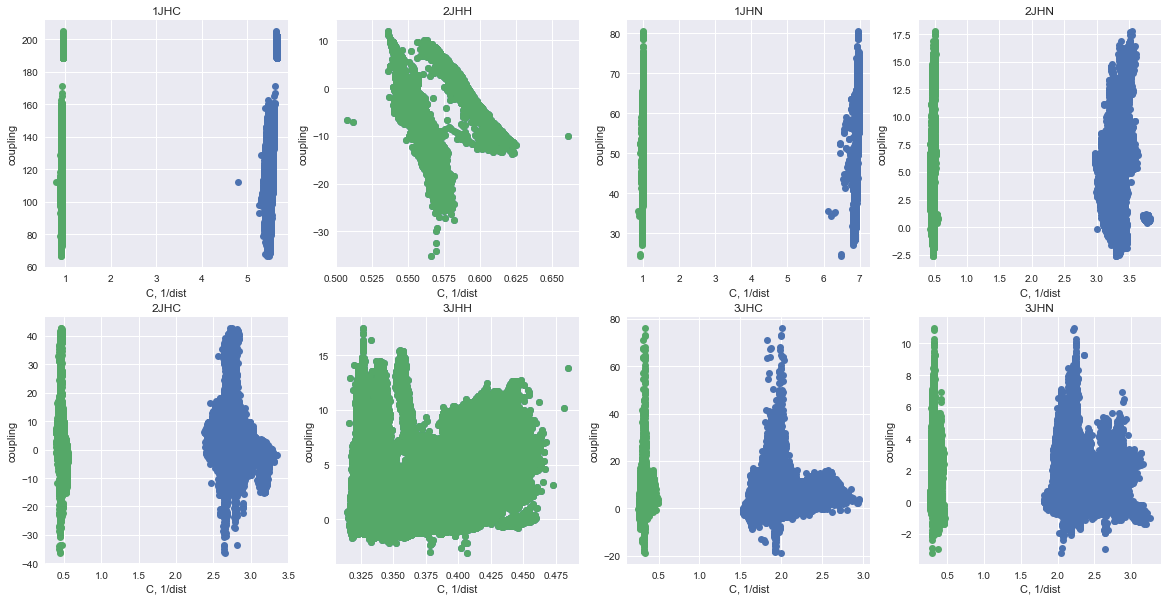

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
row = col = 0

for c_type in pd.unique(df_train['type']):
    df = df_train.loc[df_train['type'] == c_type]
    
    x = np.array(df['C']).reshape(-1, 1)
    y = np.array(df['scalar_coupling_constant']).reshape(-1, 1)
    axs[row, col].plot(x, y, 'o')
    
    x = np.array(df['dist']).reshape(-1, 1)
    axs[row, col].plot(1/x, y, 'o')
    
    axs[row, col].set_title(c_type)
    for ax in axs.flat:
        ax.set(xlabel='C, 1/dist', ylabel='coupling')
        
    col += 1
    if col > 3:
        col = 0
        row = 1

# Feature Engineering

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [20]:
#feature engineering (borrowed features from https://www.kaggle.com/kabure/lightgbm-full-pipeline-model)
def feature_engineering(df):
    print("Starting Feature Engineering...")
    df['type_0'] = df['type'].apply(lambda x: x[0])
    df['type_1'] = df['type'].apply(lambda x: x[1:])
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df['dist_to_type_mean'] = df['dist'] / df.groupby('type')['dist'].transform('mean')
    df['dist_to_type_0_mean'] = df['dist'] / df.groupby('type_0')['dist'].transform('mean')
    df['dist_to_type_1_mean'] = df['dist'] / df.groupby('type_1')['dist'].transform('mean')
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_1_dist_std'] = df.groupby(['molecule_name', 'type_1'])['dist'].transform('std')
    df[f'molecule_type_1_dist_std_diff'] = df[f'molecule_type_1_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    
    df = reduce_mem_usage(df)
    
    return df

In [21]:
df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

Starting Feature Engineering...
Mem. usage decreased to 928.45 Mb (68.5% reduction)
Starting Feature Engineering...
Mem. usage decreased to 485.06 Mb (69.1% reduction)


In [22]:
def add_C_features(df):
    df['molecule_C_mean'] = df.groupby('molecule_name')['C'].transform('mean')
    df['molecule_C_min'] = df.groupby('molecule_name')['C'].transform('min')
    df['molecule_C_max'] = df.groupby('molecule_name')['C'].transform('max')
    df[f'molecule_atom_index_0_C_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['C'].transform('mean')
    df[f'molecule_atom_index_0_C_mean_diff'] = df[f'molecule_atom_index_0_C_mean'] - df['C']
    df[f'molecule_atom_index_0_C_mean_div'] = df[f'molecule_atom_index_0_C_mean'] / df['C']
    df[f'molecule_atom_index_0_C_max'] = df.groupby(['molecule_name', 'atom_index_0'])['C'].transform('max')
    df[f'molecule_atom_index_0_C_max_diff'] = df[f'molecule_atom_index_0_C_max'] - df['C']
    df[f'molecule_atom_index_0_C_max_div'] = df[f'molecule_atom_index_0_C_max'] / df['C']
    df[f'molecule_atom_index_0_C_min'] = df.groupby(['molecule_name', 'atom_index_0'])['C'].transform('min')
    df[f'molecule_atom_index_0_C_min_diff'] = df[f'molecule_atom_index_0_C_min'] - df['C']
    df[f'molecule_atom_index_0_C_min_div'] = df[f'molecule_atom_index_0_C_min'] / df['C']
    df[f'molecule_atom_index_0_C_std'] = df.groupby(['molecule_name', 'atom_index_0'])['C'].transform('std')
    df[f'molecule_atom_index_0_C_std_diff'] = df[f'molecule_atom_index_0_C_std'] - df['C']
    df[f'molecule_atom_index_0_C_std_div'] = df[f'molecule_atom_index_0_C_std'] / df['C']
    df[f'molecule_atom_index_1_C_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['C'].transform('mean')
    df[f'molecule_atom_index_1_C_mean_diff'] = df[f'molecule_atom_index_1_C_mean'] - df['C']
    df[f'molecule_atom_index_1_C_mean_div'] = df[f'molecule_atom_index_1_C_mean'] / df['C']
    df[f'molecule_atom_index_1_C_max'] = df.groupby(['molecule_name', 'atom_index_1'])['C'].transform('max')
    df[f'molecule_atom_index_1_C_max_diff'] = df[f'molecule_atom_index_1_C_max'] - df['C']
    df[f'molecule_atom_index_1_C_max_div'] = df[f'molecule_atom_index_1_C_max'] / df['C']
    df[f'molecule_atom_index_1_C_min'] = df.groupby(['molecule_name', 'atom_index_1'])['C'].transform('min')
    df[f'molecule_atom_index_1_C_min_diff'] = df[f'molecule_atom_index_1_C_min'] - df['C']
    df[f'molecule_atom_index_1_C_min_div'] = df[f'molecule_atom_index_1_C_min'] / df['C']
    df[f'molecule_atom_index_1_C_std'] = df.groupby(['molecule_name', 'atom_index_1'])['C'].transform('std')
    df[f'molecule_atom_index_1_C_std_diff'] = df[f'molecule_atom_index_1_C_std'] - df['C']
    df[f'molecule_atom_index_1_C_std_div'] = df[f'molecule_atom_index_1_C_std'] / df['C']
    df[f'molecule_atom_1_C_mean'] = df.groupby(['molecule_name', 'atom_1'])['C'].transform('mean')
    df[f'molecule_atom_1_C_min'] = df.groupby(['molecule_name', 'atom_1'])['C'].transform('min')
    df[f'molecule_atom_1_C_min_diff'] = df[f'molecule_atom_1_C_min'] - df['C']
    df[f'molecule_atom_1_C_min_div'] = df[f'molecule_atom_1_C_min'] / df['C']
    df[f'molecule_atom_1_C_std'] = df.groupby(['molecule_name', 'atom_1'])['C'].transform('std')
    df[f'molecule_atom_1_C_std_diff'] = df[f'molecule_atom_1_C_std'] - df['C']
    df['C_to_type_mean'] = df['C'] / df.groupby('type')['C'].transform('mean')
    df['C_to_type_0_mean'] = df['C'] / df.groupby('type_0')['C'].transform('mean')
    df[f'molecule_type_0_C_std'] = df.groupby(['molecule_name', 'type_0'])['C'].transform('std')
    df[f'molecule_type_0_C_std_diff'] = df[f'molecule_type_0_C_std'] - df['C']
    df[f'molecule_type_C_mean'] = df.groupby(['molecule_name', 'type'])['C'].transform('mean')
    df[f'molecule_type_C_mean_diff'] = df[f'molecule_type_C_mean'] - df['C']
    df[f'molecule_type_C_mean_div'] = df[f'molecule_type_C_mean'] / df['C']
    df[f'molecule_type_C_max'] = df.groupby(['molecule_name', 'type'])['C'].transform('max')
    df[f'molecule_type_C_min'] = df.groupby(['molecule_name', 'type'])['C'].transform('min')
    df[f'molecule_type_C_std'] = df.groupby(['molecule_name', 'type'])['C'].transform('std')
    df[f'molecule_type_C_std_diff'] = df[f'molecule_type_C_std'] - df['C']
    return df

In [23]:
df_train = add_C_features(df_train)
df_test = add_C_features(df_test)

In [24]:
# load qm9 data
df_qm9 = pd.read_pickle('data.covs.pickle')

to_drop_qm9 = ['type', 'linear', 'atom_index_0', 'atom_index_1', 'scalar_coupling_constant', 'U', 'G', 'H', 'mulliken_mean', 'r2', 'U0']
df_qm9 = df_qm9.drop(columns = to_drop_qm9, axis=1)
df_qm9 = reduce_mem_usage(df_qm9)

df_train = pd.merge(df_train, df_qm9, how='left', on=['molecule_name','id'])
df_test = pd.merge(df_test, df_qm9, how='left', on=['molecule_name','id'])

Mem. usage decreased to 355.26 Mb (67.5% reduction)


In [25]:
good_columns = ['molecule_atom_index_0_dist_min','molecule_atom_index_0_dist_max',
                'molecule_atom_index_1_dist_min','molecule_atom_index_0_dist_mean',
                'molecule_atom_index_0_dist_std','dist','molecule_atom_index_1_dist_std',
                'molecule_atom_index_1_dist_max','molecule_atom_index_1_dist_mean',
                'molecule_atom_index_0_dist_max_diff','molecule_atom_index_0_dist_max_div',
                'molecule_atom_index_0_dist_std_diff','molecule_atom_index_0_dist_std_div',
                'atom_0_couples_count','molecule_atom_index_0_dist_min_div',
                'molecule_atom_index_1_dist_std_diff','molecule_atom_index_0_dist_mean_div',
                'atom_1_couples_count','molecule_atom_index_0_dist_mean_diff',
                'molecule_couples','atom_index_1','molecule_dist_mean',
                'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_0_y_1_std',
                'molecule_atom_index_1_dist_mean_diff','molecule_atom_index_1_dist_std_div',
                'molecule_atom_index_1_dist_mean_div', 'molecule_atom_index_1_dist_min_diff',
                'molecule_atom_index_1_dist_min_div','molecule_atom_index_1_dist_max_div',
                'molecule_atom_index_0_z_1_std', 'y_0','molecule_type_dist_std_diff',
                'molecule_atom_1_dist_min_diff','molecule_atom_index_0_x_1_std','molecule_dist_min',
                'molecule_atom_index_0_dist_min_diff', 'molecule_atom_index_0_y_1_mean_diff',
                'molecule_type_dist_min','molecule_atom_1_dist_min_div','atom_index_0',
                'molecule_dist_max','molecule_atom_1_dist_std_diff', 'molecule_type_dist_max',
                'molecule_atom_index_0_y_1_max_diff','molecule_type_0_dist_std_diff',
                'molecule_type_dist_mean_diff','molecule_atom_1_dist_mean',
                'molecule_atom_index_0_y_1_mean_div','molecule_type_dist_mean_div','type', 'scalar_coupling_constant'] + ['rc_A', 
                'rc_B', 'rc_C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'zpve', 'Cv', 'freqs_min', 'freqs_max',
                'freqs_mean', 'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1'] + ['atomic_num_0',
                'atomic_num_1'] + ['molecule_atom_index_0_C_min','molecule_atom_index_0_C_max',
                'molecule_atom_index_1_C_min','molecule_atom_index_0_C_mean',
                'molecule_atom_index_0_C_std','C','molecule_atom_index_1_C_std',
                'molecule_atom_index_1_C_max','molecule_atom_index_1_C_mean',
                'molecule_atom_index_0_C_max_diff','molecule_atom_index_0_C_max_div',
                'molecule_atom_index_0_C_std_diff','molecule_atom_index_0_C_std_div',
                'atom_0_couples_count','molecule_atom_index_0_C_min_div',
                'molecule_atom_index_1_C_std_diff','molecule_atom_index_0_C_mean_div',
                'atom_1_couples_count','molecule_atom_index_0_C_mean_diff', 'molecule_C_mean',
                'molecule_atom_index_1_C_max_diff', 'molecule_atom_index_1_C_mean_diff','molecule_atom_index_1_C_std_div',
                'molecule_atom_index_1_C_mean_div', 'molecule_atom_index_1_C_min_diff',
                'molecule_atom_index_1_C_min_div','molecule_atom_index_1_C_max_div',
                'molecule_atom_index_0_z_1_std', 'y_0','molecule_type_C_std_diff',
                'molecule_atom_1_C_min_diff', 'molecule_atom_index_0_C_min_diff', 'molecule_type_C_min','molecule_atom_1_C_min_div',
                'molecule_C_max','molecule_atom_1_C_std_diff', 'molecule_type_C_max', 'molecule_type_0_C_std_diff',
                'molecule_type_C_mean_diff','molecule_atom_1_C_mean', 'molecule_type_C_mean_div'] + ['rc_A', 
                'rc_B', 'rc_C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'zpve', 'Cv', 'freqs_min', 'freqs_max',
                'freqs_mean', 'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1'] + ['atomic_num_0',
                'atomic_num_1', 'C', 'molecule_type_C_mean']

In [34]:
df_train.shape

(4658147, 144)

In [ ]:
#df_train[good_columns].mean()

In [ ]:
#plt.bar(df_train[good_columns].mean())

In [29]:
#encode labels
for f in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type', 'atom_index_0', 'atom_index_1']:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[f].values) + list(df_test[f].values))
    df_train[f] = lbl.transform(list(df_train[f].values))
    df_test[f] = lbl.transform(list(df_test[f].values))

In [6]:
# find correlated features
corr_matrix = df_train[df_train['scalar_coupling_constant'].notnull()].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_matrix#[['scalar_coupling_constant']].T

,id,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1
id,1.000000,0.200476,0.056080,0.006968,0.063553,0.184992,0.028264,0.087629,0.229034,0.030272
atom_index_0,0.200476,1.000000,0.145740,0.018839,0.020848,0.521941,0.078614,0.030623,0.366010,0.021815
atom_index_1,0.056080,0.145740,1.000000,0.218989,0.008809,0.104602,0.005917,0.000755,0.179888,0.056477
scalar_coupling_constant,0.006968,0.018839,0.218989,1.000000,0.006015,0.013119,0.004807,0.005132,0.021189,0.007792
x_0,0.063553,0.020848,0.008809,0.006015,1.000000,0.137042,0.009599,0.637212,0.172400,0.022365
y_0,0.184992,0.521941,0.104602,0.013119,0.137042,1.000000,0.010514,0.157436,0.721484,0.018929
z_0,0.028264,0.078614,0.005917,0.004807,0.009599,0.010514,1.000000,0.004632,0.016645,0.540027
x_1,0.087629,0.030623,0.000755,0.005132,0.637212,0.157436,0.004632,1.000000,0.193026,0.011105
y_1,0.229034,0.366010,0.179888,0.021189,0.172400,0.721484,0.016645,0.193026,1.000000,0.029796
z_1,0.030272,0.021815,0.056477,0.007792,0.022365,0.018929,0.540027,0.011105,0.029796,1.000000


In [7]:
correlation = df_train.corr()

In [12]:
%matplotlib inline
f = plt.figure(figsize=(100, 100))
corr_matrix.style.background_gradient(cmap='coolwarm')

,id,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1
id,1,0.200476,0.0560798,0.0069681,0.0635525,0.184992,0.028264,0.0876292,0.229034,0.0302724
atom_index_0,0.200476,1,0.14574,0.0188393,0.0208483,0.521941,0.0786142,0.0306231,0.36601,0.0218152
atom_index_1,0.0560798,0.14574,1,0.218989,0.00880881,0.104602,0.00591651,0.000755068,0.179888,0.0564767
scalar_coupling_constant,0.0069681,0.0188393,0.218989,1,0.00601535,0.0131193,0.00480695,0.00513204,0.0211891,0.00779161
x_0,0.0635525,0.0208483,0.00880881,0.00601535,1,0.137042,0.00959858,0.637212,0.1724,0.022365
y_0,0.184992,0.521941,0.104602,0.0131193,0.137042,1,0.0105141,0.157436,0.721484,0.0189286
z_0,0.028264,0.0786142,0.00591651,0.00480695,0.00959858,0.0105141,1,0.00463211,0.0166448,0.540027
x_1,0.0876292,0.0306231,0.000755068,0.00513204,0.637212,0.157436,0.00463211,1,0.193026,0.0111054
y_1,0.229034,0.36601,0.179888,0.0211891,0.1724,0.721484,0.0166448,0.193026,1,0.0297956
z_1,0.0302724,0.0218152,0.0564767,0.00779161,0.022365,0.0189286,0.540027,0.0111054,0.0297956,1


<Figure size 7200x7200 with 0 Axes>

In [ ]:
# select columns with correlations above threshold
threshold = 0.97
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

In [ ]:
df_train = df_train.drop(to_drop, axis=1)
df_test = df_test.drop(to_drop, axis=1)

In [ ]:
df_train.head()

In [ ]:
np.array(df_train.columns)

# Preprocessing

In [ ]:
def preprocess(df):
    df = pd.DataFrame()
    for column in good_columns:
        if column not in to_drop:
            df[column] = df_train[column]
    df = df.fillna(0)
    return df

In [ ]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)
df_test.head()

# Modeling

In [ ]:
param = {'boosting': 'gbdt', 'colsample_bytree': 1, 
          'learning_rate': 0.1, 'max_depth': 40, 'metric': 'mae',
          'min_child_samples': 50, 'num_leaves': 500, 
          'objective': 'regression', 'reg_alpha': 0.5, 
          'reg_lambda': 0.8, 'subsample': 0.5 }

param_2 = {'num_leaves': 128, 'min_child_samples': 79, 'objective': 'regression',
          'max_depth': 9, 'learning_rate': 0.25,
          "boosting_type": "gbdt", "subsample_frr0eq": 1, "subsample": 0.9,
          "bagging_seed": 11, "metric": 'mae', "verbosity": -1, 
          'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 1.0 }

## Single Model

In [ ]:
def group_mean_log_mae(y_true, y):
    gmlmae = 0
    train_sample_size = int(df_train.shape[0]*0.7)
    for c_type in pd.unique(df_train[train_sample_size:]['type']):
        n_t = df_train[train_sample_size:].loc[df_train[train_sample_size:]['type'] == c_type].shape[0]
        y_true_t = y_true[df_train[train_sample_size:]['type'] == c_type]
        y_t = y[df_train[train_sample_size:]['type'] == c_type]
        mean_abs_err = np.sum(abs(y_true_t - y_t))/n_t
        lmae = np.log(mean_abs_err)
        gmlmae += lmae
    return gmlmae/df_train[train_sample_size:]['type'].nunique()

In [ ]:
train_sample_size = int(df_train.shape[0]*0.7)
df_train_x = df_train[:train_sample_size].drop('scalar_coupling_constant', axis=1)
df_train_y = df_train[:train_sample_size][['scalar_coupling_constant']]

df_val_x = df_train[train_sample_size:].drop('scalar_coupling_constant', axis=1)
df_val_y = df_train[train_sample_size:][['scalar_coupling_constant']]

lgtrain = lgb.Dataset(df_train_x, label=df_train_y)
lgval = lgb.Dataset(df_val_x, label=df_val_y)
model_lgb = lgb.train(param, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], early_stopping_rounds=250, 
                      verbose_eval=500)
        
#model_lgb = lgb.LGBMRegressor(**param, n_estimators = 3000, n_jobs = -1)
#model_lgb.fit(df_train_x, df_train_y, 
              #eval_set=[(df_train_x, df_train_y), (df_val_x, df_val_y)], eval_metric='mae',
              #verbose=500, early_stopping_rounds=200)

In [ ]:
prediction = model_lgb.predict(df_val_x)
group_mean_log_mae(np.array(df_val_y).flatten(), prediction)

## Types Seperately 

In [ ]:
def group_mean_log_mae_t(y_true, y):
    n_t = y_true.shape[0]
    mean_abs_err = np.sum(abs(y_true - y))/n_t
    return np.log(mean_abs_err)

In [ ]:
for i, c_type in enumerate(pd.unique(df_train['type'])):
    df_train_x = df_train.loc[df_train['type'] == c_type].drop('scalar_coupling_constant', axis=1)
    df_train_y = df_train.loc[df_train['type'] == c_type][['scalar_coupling_constant']]

    train_sample_size = int(df_train_x.shape[0]*0.7)

    lgtrain = lgb.Dataset(df_train_x[:train_sample_size], label=df_train_y[:train_sample_size])
    lgval = lgb.Dataset(df_train_x[train_sample_size:], label=df_train_y[train_sample_size:])
    print(f'type:{c_type}')
    model_lgb = lgb.train(param, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], early_stopping_rounds=250, 
                      verbose_eval=500)
    prediction = model_lgb.predict(df_train_x[train_sample_size:])
    print(f"group_mean_log_mae:{group_mean_log_mae_t(np.array(df_train_y[train_sample_size:]).flatten(), prediction)}\n")

# Submission

In [ ]:
submission = pd.read_csv('champs-scalar-coupling/sample_submission.csv')

In [ ]:
for i, c_type in enumerate(pd.unique(df_train['type'])):
    df_train_x = df_train.loc[df_train['type'] == c_type].drop('scalar_coupling_constant', axis=1)
    df_train_y = df_train.loc[df_train['type'] == c_type][['scalar_coupling_constant']]

    df_test_x = df_test.loc[df_test['type'] == c_type]

    train_sample_size = int(df_train_x.shape[0]*0.9)

    lgtrain = lgb.Dataset(df_train_x[:train_sample_size], label=df_train_y[:train_sample_size])
    lgval = lgb.Dataset(df_train_x[train_sample_size:], label=df_train_y[train_sample_size:])
    print(f'type:{c_type}')
    model_lgb = lgb.train(param, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], early_stopping_rounds=250, 
                      verbose_eval=500)

    prediction = model_lgb.predict(df_test_x)

    df = pd.DataFrame()
    df['id'] = submission.loc[df_test['type'] == c_type]['id']
    df['scalar_coupling_constant'] = prediction
    submission.loc[df_test['type'] == c_type] = df

In [ ]:
# sanity check
best_submission = pd.read_csv('best_submission.csv')
mean_absolute_error(np.array(best_submission['scalar_coupling_constant']).flatten(), submission['scalar_coupling_constant'])

In [ ]:
submission.to_csv('submission.csv', index=False)